In [1]:
import os
import glob
import pickle
import openpyxl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
print(np.__version__)

from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

from matplotlib import cm
from matplotlib.colors import Normalize, to_hex

import seaborn as sns


1.21.0


In [2]:
DATA_FOLDER = "/home/hjlee/monocle3,pyscenic,palantir,iqcell/DATA_FOLDER"
RESOURCES_FOLDER = "/home/hjlee/monocle3,pyscenic,palantir,iqcell/RESOURCES_FOLDER"
DATABASE_FOLDER = "/home/hjlee/monocle3,pyscenic,palantir,iqcell/DATABASE_FOLDER"
EXPRESSIONDATA_FOLDER = "/home/hjlee/monocle3,pyscenic,palantir,iqcell/EXPRESSIONDATA_FOLDER"


DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather")
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.hgnc-m0.001-o0.0.tbl")
MM_TFS_FNAME = os.path.join(RESOURCES_FOLDER, 'hs_hgnc_tfs.txt')
SC_EXP_FNAME = os.path.join(EXPRESSIONDATA_FOLDER, "20250625_renal_raw.csv")
REGULONS_FNAME = os.path.join(DATA_FOLDER, "20250522_regulons_all_gene.p") # for save
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "20250522_motifs_all_gene.csv") # for save

ex_matrix = pd.read_csv(SC_EXP_FNAME, header=0, index_col=0).T # for making cell (row) and gene (column)
ex_matrix.shape 
tf_names = load_tf_names(MM_TFS_FNAME)


db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs


[FeatherRankingDatabase(name="hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings")]

In [3]:
# STEP1 : co-expression-based TF-target interference using GRNBoost2 algorithm 
# Regulons are derived from adjacencies using arboreto package
adjacencies = grnboost2(ex_matrix, tf_names=tf_names, verbose=True)

# STEP2 : TF is added to the module & modules that have less than 20 genes are removed
modules = list(modules_from_adjacencies(adjacencies, ex_matrix))

# Calculate a list of enriched motifs and the corresponding target genes for all modules.
with ProgressBar():
    df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

# Create regulons from this table of enriched motifs
regulons = df2regulons(df)

# Save the enriched motifs and the discovered regulons to disk.
df.to_csv(MOTIFS_FNAME)
with open(REGULONS_FNAME, "wb") as f:
    pickle.dump(regulons, f)

# The clusters can be leveraged via the dask framework:
df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

# STEP3 : Reloading the enriched motifs and regulons from file  
df = load_motifs(MOTIFS_FNAME)
with open(REGULONS_FNAME, "rb") as f:
    regulons = pickle.load(f)

preparing dask client


/data/hjlee/sw/miniconda3/envs/pyscenic/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44993 instead
  warnings.warn(
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in

parsing input
creating dask graph
14 partitions
computing dask graph


/data/hjlee/sw/miniconda3/envs/pyscenic/lib/python3.8/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 143.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


shutting down client and local cluster
finished



2025-06-25 22:55:32,520 - pyscenic.utils - INFO - Calculating Pearson correlations.

2025-06-25 22:55:32,598 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2025-06-25 22:55:35,491 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 388.69 s
Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [4]:
adjacencies.head()

,TF,target,importance
16,NFIA,RCBTB1,12.105061
409,FOXI2,NRIP3,11.992420
69,LTF,SERPINA3,11.053594
256,PKM,ALDOA,10.717265
101,BDP1,ZNF430,10.650527


In [5]:
adjacencies.to_csv('/home/hjlee/monocle3,pyscenic,palantir,iqcell/20250625_adjacencies.csv')

In [6]:
auc_mtx = aucell(ex_matrix, regulons)
print(auc_mtx)

Regulon                             ARID3A(+)  ASCL2(+)   ATF3(+)   ATF4(+)  \
Cell                                                                          
5739STDY7958794_ACGCCAGAGATGTAAC-1        0.0       0.0  0.022921  0.039179   
5739STDY7958794_AGCCTAAAGCTAGTCT-1        0.0       0.0  0.052775  0.048351   
5739STDY7958794_CTGGTCTCATCGATGT-1        0.0       0.0  0.020725  0.002257   
5739STDY7958794_TCACAAGGTATTAGCC-1        0.0       0.0  0.050517  0.040805   
5739STDY7958794_TCGAGGCAGGACAGAA-1        0.0       0.0  0.133407  0.034419   
...                                       ...       ...       ...       ...   
5739STDY9266997_GTACGTAAGAATAGGG-1        0.0       0.0  0.035427  0.025190   
5739STDY9266997_TACACGAAGGTGCTAG-1        0.0       0.0  0.019814  0.024023   
5739STDY9266997_TACTTGTGTACCATCA-1        0.0       0.0  0.020339  0.034640   
5739STDY9266997_TCATTACAGGTGTTAA-1        0.0       0.0  0.021444  0.032971   
5739STDY9266997_TGCTACCAGTGGAGAA-1        0.0       

In [7]:
auc_mtx.columns

Index(['ARID3A(+)', 'ASCL2(+)', 'ATF3(+)', 'ATF4(+)', 'ATF5(+)', 'BACH2(+)',
       'BATF3(+)', 'BBX(+)', 'BCL6(+)', 'BCLAF1(+)',
       ...
       'WT1(+)', 'XBP1(+)', 'YBX1(+)', 'ZMIZ1(+)', 'ZNF217(+)', 'ZNF430(+)',
       'ZNF607(+)', 'ZNF76(+)', 'ZNF780B(+)', 'ZNF844(+)'],
      dtype='object', name='Regulon', length=139)

                              cell_id  pseudotime cell_type
0  5739STDY8351266_TATTACCGTTTGCATG-1    0.000000    Epi_PT
1  5739STDY9266980_TACTTACTCAGCATGT-1    0.000161    Epi_PT
2  5739STDY8351266_ACACCGGGTATATCCG-1    0.000519    Epi_PT
3  5739STDY8351266_GCTGGGTAGTACATGA-1    0.000641    Epi_PT
4  5739STDY9266998_ATTCTACCAGGGTACA-1    0.000964    Epi_PT


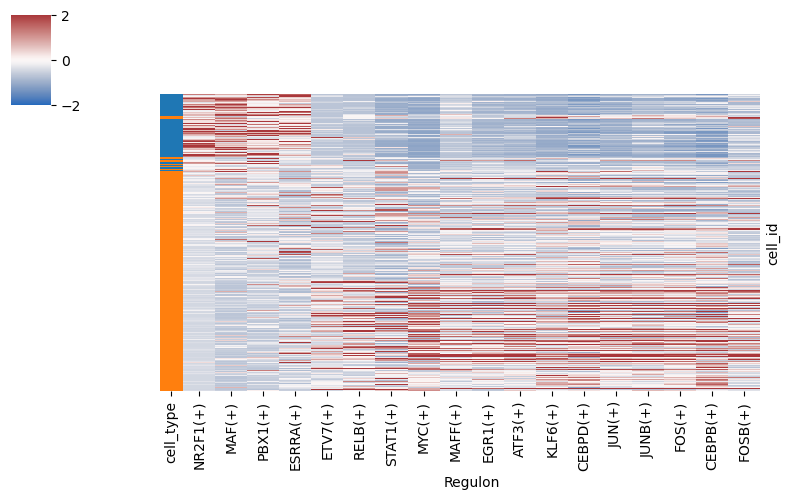

In [ ]:
# We characterize the different cells in a single-cell transcriptomics experiment via the enrichment of the previously discovered regulons. 
# Enrichment of a regulon is measured as the Area Under the recovery Curve (AUC) of the genes that define this regulon.
auc_mtx = aucell(ex_matrix, regulons)
auc_df = auc_mtx.copy()
auc_df.index.name = 'cell_id'
auc_df.reset_index(inplace=True)

umap_df = pd.read_csv("/home/hjlee/monocle3,pyscenic,palantir,iqcell/20250625_order.csv")
print(umap_df.head())

umap_df_sub = pd.merge(umap_df, auc_df, on='cell_id', how='inner')
umap_df_sub.to_csv('/home/hjlee/monocle3,pyscenic,palantir,iqcell/20250625_auc_matrix_meta_all_gene.csv')
umap_df_sub.set_index("cell_id", inplace=True)

# 0이 50% 미만인 열만 선택 (0이 많은 열 제거)
threshold = 0.5
zero_fraction = (umap_df_sub == 0).sum() / umap_df_sub.shape[0]
cols_to_keep = zero_fraction[zero_fraction < threshold].index
umap_df_sub = umap_df_sub[cols_to_keep]

unique_btypes = sorted(umap_df_sub["broad_type"].dropna().unique())
palette = sns.color_palette("tab10", n_colors=len(unique_btypes))
lut = dict(zip(unique_btypes, palette))
row_colors = umap_df_sub.reindex(auc_mtx.index)["broad_type"].map(lut)

auc_mtx = auc_mtx.loc[umap_df_sub.index]
# heatmap
selected_genes = ['NR2F1(+)','MAF(+)', 'ESRRA(+)','ETV7(+)','RELB(+)','STAT1(+)','MYC(+)','MAFF(+)','EGR1(+)','ATF3(+)','KLF6(+)','CEBPD(+)','JUN(+)','JUNB(+)','FOS(+)','CEBPB(+)','FOSB(+)']

auc_mtx_filtered = auc_mtx[selected_genes]
sns.clustermap(
    auc_mtx_filtered,
    figsize=(8, 5),
    row_colors=row_colors,
    z_score=1,
    vmin=-2,
    vmax=2,
    cmap="vlag",
    row_cluster=False,
    col_cluster=False,
    yticklabels=False
)
auc_mtx.to_csv("/home/hjlee/monocle3,pyscenic,palantir,iqcell/20250625_auc_matrix_all_gene.csv")
plt.savefig('/home/hjlee/monocle3,pyscenic,palantir,iqcell/20250625_AUCell_all_gene.png')
plt.show()